In [51]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
from astropy.io import fits
from astropy.nddata import CCDData
import astropy.units as u
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator
import cmcrameri.cm as cmcm
from juanfit import SpectrumFitSingle, SpectrumFitRow
from specutils.utils.wcs_utils import vac_to_air, air_to_vac
from scipy import ndimage
import cv2


In [2]:
with h5py.File("../../sav/Eclipse/Bias/master_bias_dc_red_1s_proto.h5", 'r') as hf:
    bias_dc_red_1s = hf['image'][:]


In [3]:
red_path = "../../src/EclipseSpectra2017/MikesData/VaderEclipseDayRed2017aug21/"
with h5py.File("../../sav/Eclipse/Curvature/master_curvature_red.h5", 'r') as hf:
    xpos_map_coordinate = hf['xpos_map_coordinate'][:]
    xstart_pixel = hf['xpos_map_coordinate'].attrs['xstart_pixel']
    xend_pixel = hf['xpos_map_coordinate'].attrs['xend_pixel']

    ypos_map_coordinate = hf['ypos_map_coordinate'][:]
    ystart_pixel = hf['ypos_map_coordinate'].attrs['ystart_pixel']
    yend_pixel = hf['ypos_map_coordinate'].attrs['yend_pixel']


In [4]:
totality_image_fname = "TotalitySequenceRed_7723.fit"
totality_frame = CCDData.read(os.path.join(red_path, totality_image_fname),unit="adu")

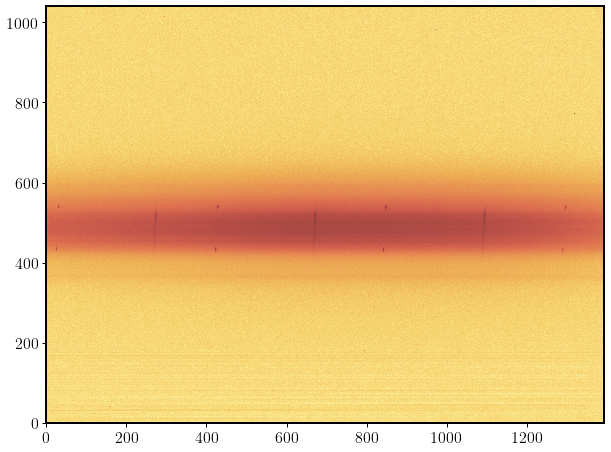

In [5]:
totality_image = (totality_frame.data - bias_dc_red_1s)//totality_frame.header["EXPTIME"]
norm_totality = ImageNormalize(totality_image, stretch=LogStretch())
fig, ax = plt.subplots(figsize=(10,8))
ax.pcolormesh(np.arange(1392),np.arange(1040),totality_image,norm=norm_totality,cmap=cmcm.lajolla, rasterized=True)
ax.axis("scaled")
ax.tick_params(labelsize=16)

In [189]:
testx_slice_mapcoor = slice(xstart_pixel,xend_pixel)
testy_slice_mapcoor = slice(ystart_pixel,yend_pixel)
totality_trans_mapcoor = ndimage.map_coordinates(totality_image[testy_slice_mapcoor, testx_slice_mapcoor],(ypos_map_coordinate, xpos_map_coordinate),
                                                order=1)

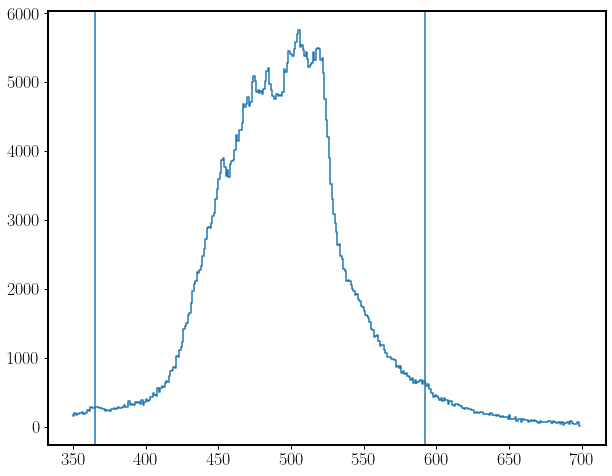

In [210]:
fig, ax = plt.subplots(figsize=(10,8))
ax.step(np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop), 
        np.mean(totality_trans_mapcoor[:,665-xstart_pixel:669-xstart_pixel],axis=1))
north_limb = 592
south_limb = 365
ax.axvline(south_limb)
ax.axvline(north_limb)
ax.tick_params(labelsize=18)

In [99]:
def ypixel_to_solary(ccdy_pixel):
    return (np.float64(ccdy_pixel) - (north_limb+south_limb)/2.)/(north_limb-south_limb+1)*2.

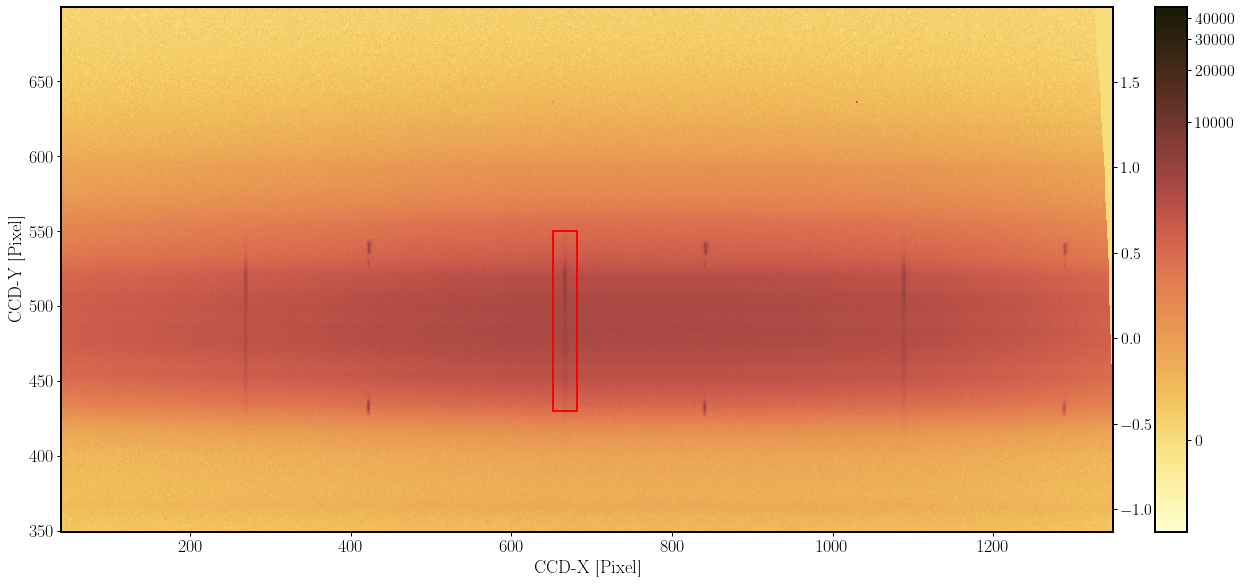

In [214]:
fig, ax = plt.subplots(figsize=(16,8),constrained_layout=True)
im = ax.pcolormesh(np.arange(testx_slice_mapcoor.start,testx_slice_mapcoor.stop),np.arange(testy_slice_mapcoor.start,testy_slice_mapcoor.stop),
            totality_trans_mapcoor,norm=norm_totality,cmap=cmcm.lajolla,rasterized=True)
ax.tick_params(labelsize=18)
FeX_6374_52th_xslice = slice(612,642)
FeX_6374_52th_yslice = slice(430 - ystart_pixel,550 - ystart_pixel)
solar_ycoord = ypixel_to_solary(np.arange(1040,dtype=np.float64))
solar_ycoord = solar_ycoord[testy_slice_mapcoor]
FeX_6374_52th_ycoord = solar_ycoord[FeX_6374_52th_yslice]

ax_solary = ax.twinx()
ax_solary_bot, ax_solary_top =  ypixel_to_solary(ax.get_ylim())
ax_solary.set_ylim(ax_solary_bot, ax_solary_top)
ax_solary.tick_params(labelsize=16)

ax.set_xlabel("CCD-X [Pixel]",fontsize=18)
ax.set_ylabel("CCD-Y [Pixel]",fontsize=18)

cutout_rectangle_52th = Rectangle((FeX_6374_52th_xslice.start + xstart_pixel, FeX_6374_52th_yslice.start + ystart_pixel), 
                    FeX_6374_52th_xslice.stop - FeX_6374_52th_xslice.start,
                    FeX_6374_52th_yslice.stop - FeX_6374_52th_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)

ax.add_patch(cutout_rectangle_52th)

clb_ax = inset_axes(ax,width="3%",height= "100%",loc='lower left',
                bbox_to_anchor=(1.04, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
clb_ax.tick_params(labelsize=16)
clb_ax.yaxis.get_offset_text().set_fontsize(16)
clb_ax.set_ylabel('',fontsize=16)
plt.savefig(fname="../../figs/calib/data_example_red_7723_curvature_corr.png",format="png",dpi=150)

In [8]:
with Image.open("../../sav/Eclipse/Video/frame112.jpg") as im:
    totality_context = np.asarray(im)

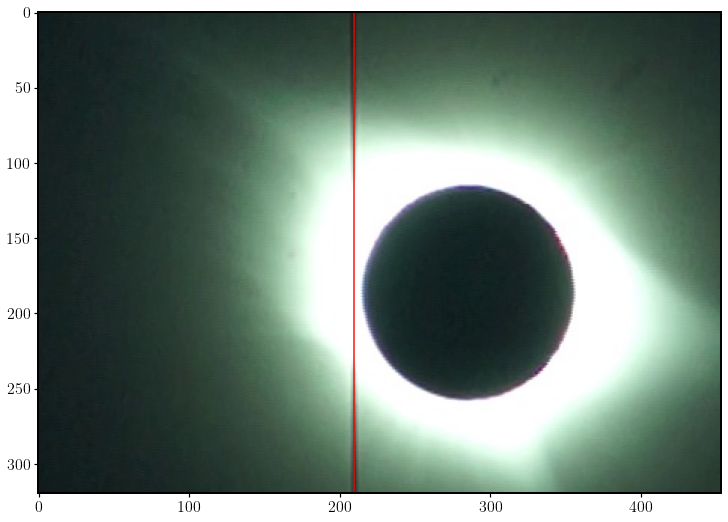

In [213]:
video_vertical_slice =  slice(390,710)
video_horizontal_slice = slice(746,1200)

slit_pos = 209.4
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.imshow(totality_context[video_vertical_slice,video_horizontal_slice,:])
ax.axvline(slit_pos,color="red",lw=2,alpha=0.7)
ax.axis("scaled")
ax.tick_params(labelsize=16,length=4,width=1.2)
plt.savefig(fname="../../figs/calib/data_example_context.png",format="png",dpi=150)

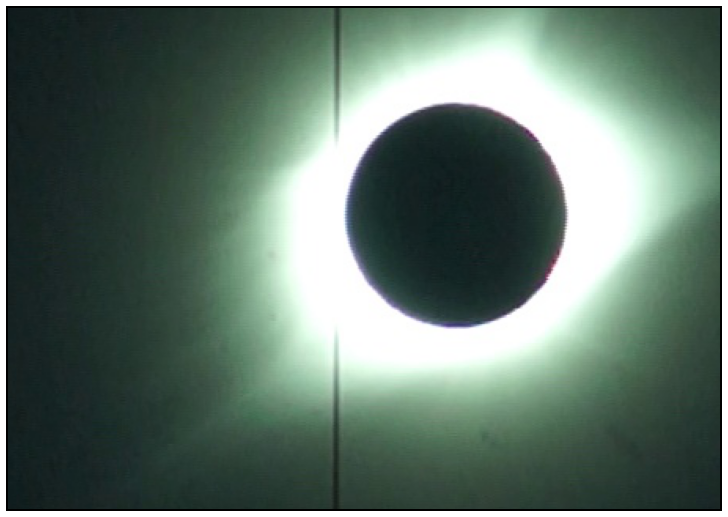

In [227]:
totality_context_flip = np.flip(totality_context[video_vertical_slice,video_horizontal_slice,:],axis=0)
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.imshow(totality_context_flip)
ax.axis("scaled")
ax.tick_params(labelsize=16,length=4,width=1.2)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
#plt.savefig("../../figs/WL_context_ud_flip.png",format="png",dpi=300)

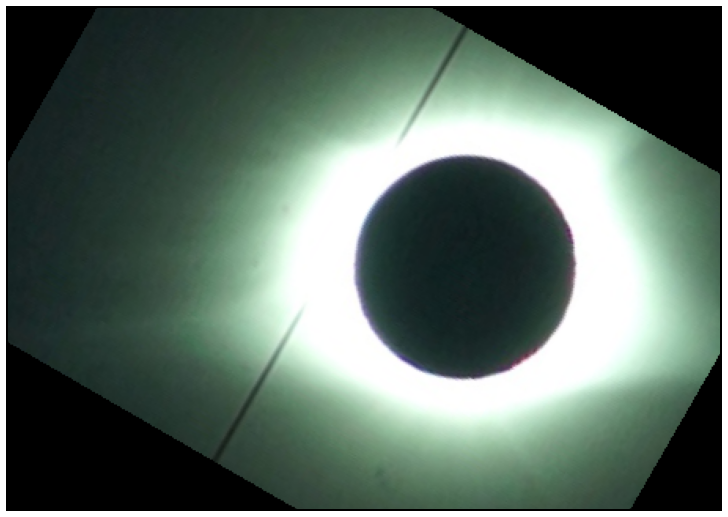

In [229]:
totality_context_rot_scipy = ndimage.rotate(totality_context_flip, angle=-30,reshape=False,order=1)
fig, ax = plt.subplots(figsize=(10,8),constrained_layout=True)
ax.imshow(totality_context_rot_scipy)
ax.axis("scaled")
ax.tick_params(labelsize=16,length=4,width=1.2)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
#plt.savefig("../../figs/WL_context_ud_flip.png",format="png",dpi=300)

In [39]:
with h5py.File("../../sav/Eclipse/Wavelength/master_wavelength_curvature_red.h5", 'r') as hf:
    wavelength_times_order = hf['wavelength_times_order'][:]

In [40]:
wavelength_52th = wavelength_times_order/52.

In [192]:
FeX_6374_52th_data = totality_trans_mapcoor[FeX_6374_52th_yslice, FeX_6374_52th_xslice]
FeX_6374_52th_data_aver = np.mean(FeX_6374_52th_data.reshape((-1,5,30)),axis=1)
FeX_6374_52th_wvl = wavelength_52th[FeX_6374_52th_xslice]
FeX_6374_52th_ycoord_aver = np.mean(FeX_6374_52th_ycoord.reshape(-1,5),axis=1)

FeX_6374_52th_models = SpectrumFitRow(data=FeX_6374_52th_data_aver,wvl=FeX_6374_52th_wvl,line_number=1,
                                        line_wvl_init=6374.5,int_max_init=800,fwhm_init=1)

In [193]:
FeX_6374_52th_models.run_lse()

/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:204: UserWarning: No input errors, absolute_sigma=False will be used in the Chi2 fitting.
  warn("No input errors, absolute_sigma=False will be used in the Chi2 fitting.")


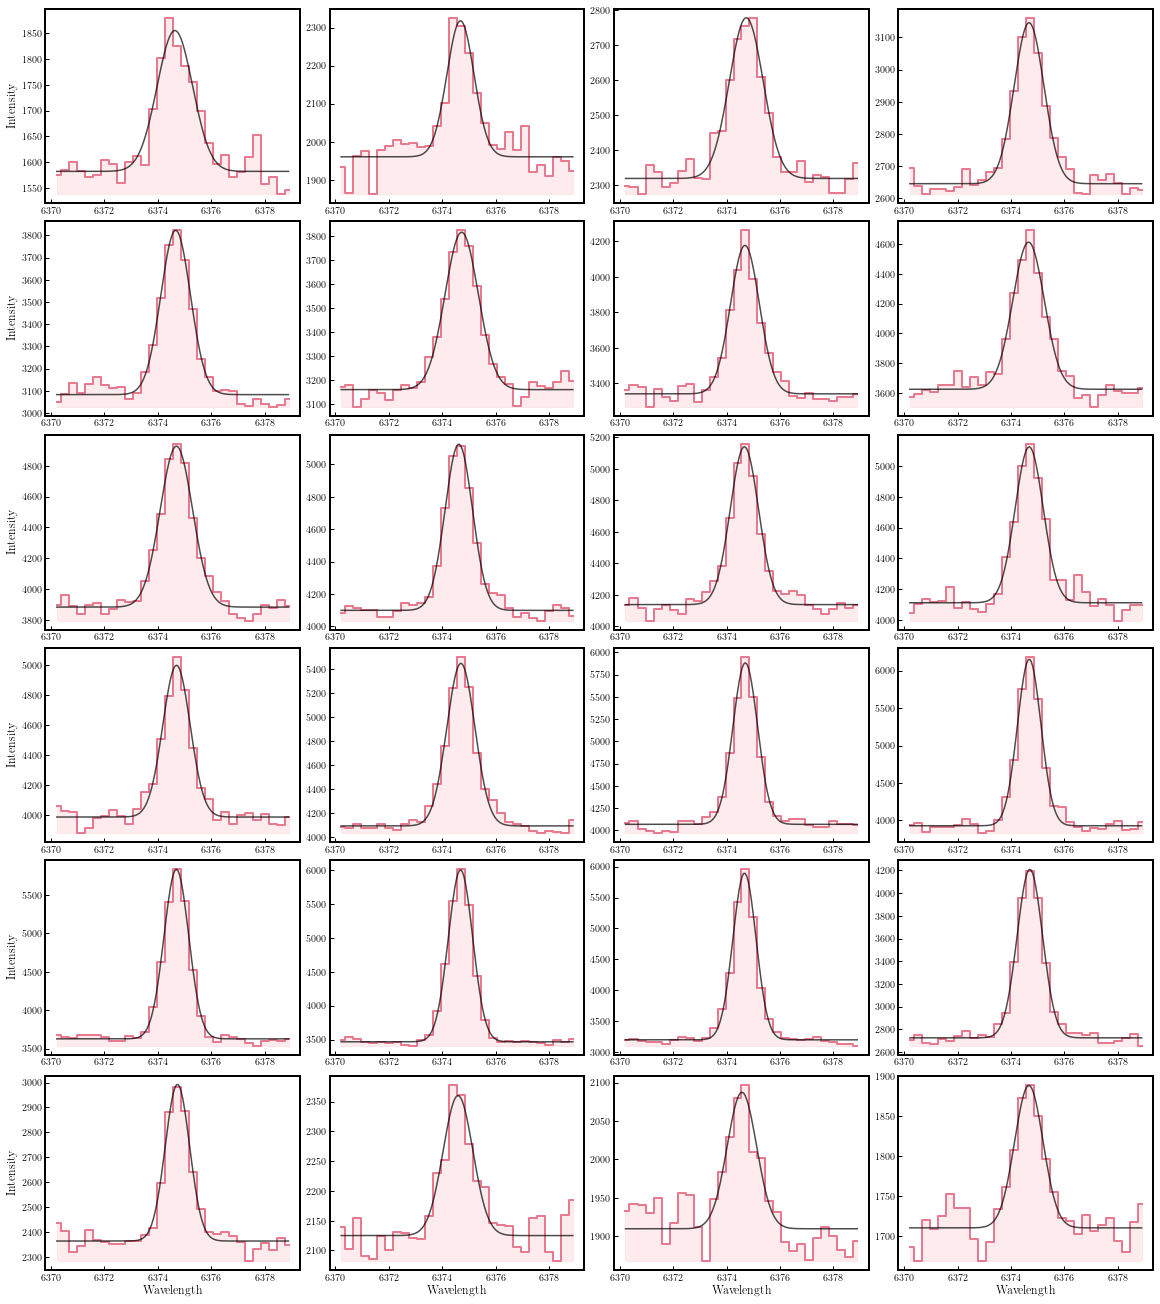

In [194]:
axes = FeX_6374_52th_models.plot_fit()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


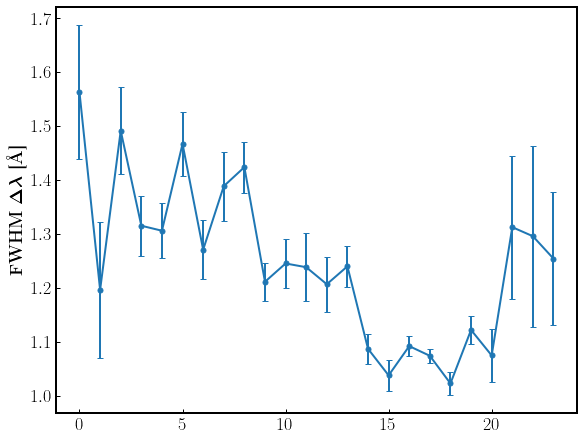

In [226]:
FeX_6374_52th_models.plot_variation(
                                    ylabel=r"\textbf{FWHM}\ $\boldsymbol{\Delta \lambda\ }$\textbf{[\mbox{\AA}]}")
plt.savefig(fname="../../figs/calib/data_fwhm_red_7723.png",format="png",dpi=150)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


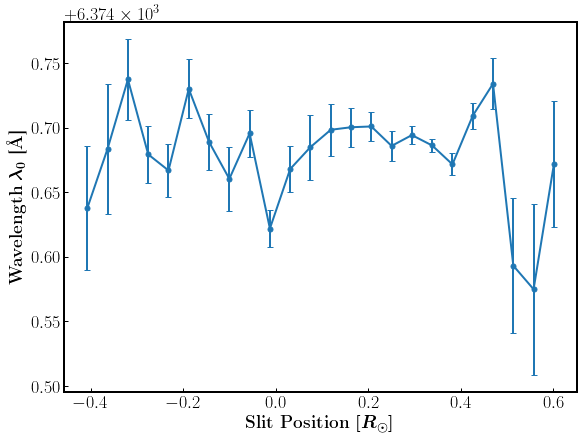

In [218]:
ax = FeX_6374_52th_models.plot_variation(var="wvl",xdata=FeX_6374_52th_ycoord_aver,xlabel=r"\textbf{Slit Position}\ $\boldsymbol{[R_\odot]}$",
                                    ylabel=r"\textbf{Wavelength}\ $\boldsymbol{\lambda_0\ }$\textbf{[\mbox{\AA}]}")
ax.yaxis.get_offset_text().set_fontsize(18)
plt.savefig(fname="../../figs/calib/data_linewvl_red_7723.png",format="png",dpi=150)

In [159]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
sun_center

(371.9, 382.85)

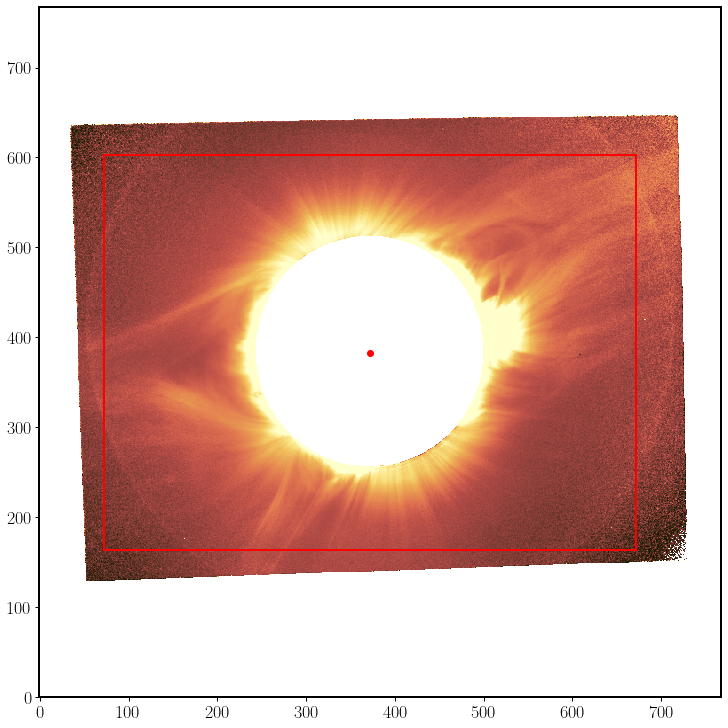

In [164]:
norm_FeXI_line_cont = ImageNormalize(FeXI_line_cont_image, interval=ZScaleInterval())
FeXI_line_cont_xslice = slice(372-300,372+300)
FeXI_line_cont_yslice = slice(383-220,383+220)


fig, ax = plt.subplots(figsize=(10,10),constrained_layout=True)
ax.pcolormesh(np.arange(FeXI_line_cont_frame.header["NAXIS1"]),np.arange(FeXI_line_cont_frame.header["NAXIS2"]),
                FeXI_line_cont_image,rasterized=True,cmap=cmcm.lajolla_r,norm=norm_FeXI_line_cont)

cutout_FeXI_line_cont = Rectangle((FeXI_line_cont_xslice.start, FeXI_line_cont_yslice.start), 
                    FeXI_line_cont_xslice.stop - FeXI_line_cont_xslice.start,
                    FeXI_line_cont_yslice.stop - FeXI_line_cont_yslice.start,
                    edgecolor="red",facecolor='none',lw=2)

ax.add_patch(cutout_FeXI_line_cont)

ax.tick_params(labelsize=18)
ax.scatter(sun_center[0],sun_center[1],color="red")


In [168]:
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center[0] - FeXI_line_cont_xslice.start, sun_center[1] - FeXI_line_cont_yslice.start)

In [205]:
FeXI_line_cont_image_rotmatrix = cv2.getRotationMatrix2D(center=FeXI_rotate_center, angle=np.float64(FeXI_line_cont_frame.header["SUNROT"]), scale=1)
FeXI_line_cont_image_rot = cv2.warpAffine(src=FeXI_line_cont_cutout, M=FeXI_line_cont_image_rotmatrix,
                dsize=FeXI_line_cont_cutout.shape,flags=cv2.INTER_LINEAR)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [181]:
FeXI_line_cont_image_rot_scipy.shape

(440, 600)

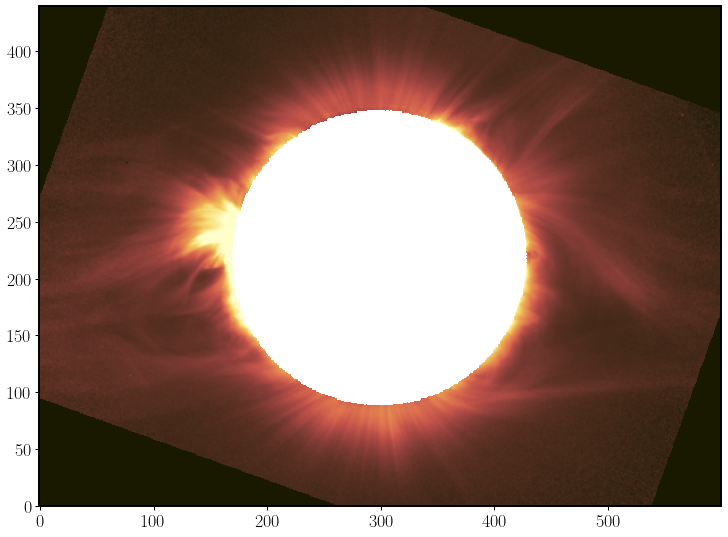

In [221]:
fig, ax = plt.subplots(figsize=(10,10),constrained_layout=True)
ax.imshow(FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,cmap=cmcm.lajolla_r,origin="lower")
ax.tick_params(labelsize=18)
plt.savefig("../../figs/FeXI_reference_ben.png",format="png",dpi=300)
# ax.pcolormesh(np.arange(FeXI_line_cont_frame.header["NAXIS1"]),np.arange(FeXI_line_cont_frame.header["NAXIS2"]),
#                 FeXI_line_cont_image_rot,rasterized=True,cmap=cmcm.lajolla_r,norm=norm_FeXI_line_cont)

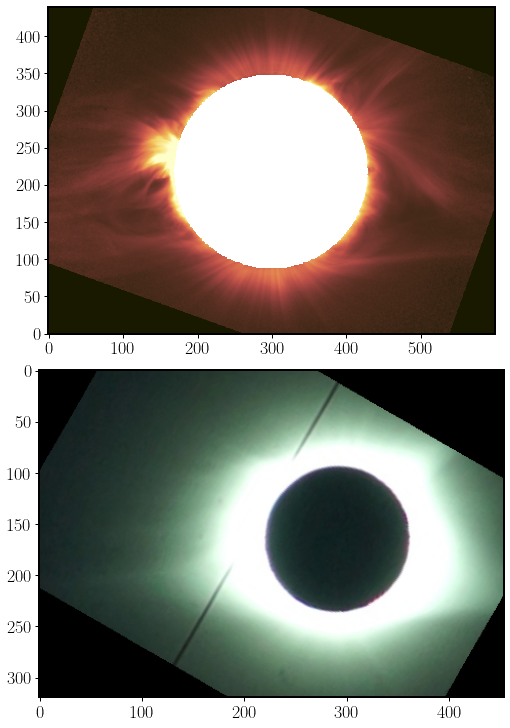

In [230]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,10),constrained_layout=True)
ax1.imshow(FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,cmap=cmcm.lajolla_r,origin="lower")
ax2.imshow(totality_context_rot_scipy)


for ax_ in (ax1,ax2):   
    ax_.tick_params(labelsize=18)